# Metabolic modelling of artemisinin biosynthetsis in E. coli: Optimisation of the production through Flux-Balance Analysis
*28 May 2019 Miroslav Gasparek*

*Note: The following project is based on the Problem 9.3, Chapter 9 ("Metabolism") of the fantastic textbook "Fundamentals of Systems Biology" by Markus W. Covert*
<br>
<br>

In [25]:
# Numerical & data modules
import numpy as np
import pandas as pd

# Convex optimisation module
import cvxpy as cvx

import os
import re

# Import Matplotlib
import matplotlib.pyplot as plt

# Import function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline


## Introduction
Artemisinin is an antimalarial drug that represents the standard treatment for the malaria disease. This drug was intially extracted from the plant *Artemisia annua*, sweet wormwood, which was used in the Chinese traditional medicine. Actually, Tu Youyou, a Chinese scientist that discovered this drug was awarded a half of the 2015 Nobel Prize in Medicine for its discovery!

As you can imagine, the manufacturing from the exotic plant is not very efficient, and is expensive. Therefore, Jay Keasling and his lab at the University of California at Berkeley decided to use genetically modify the yeasts that could manufacture the artemisinin much more effectively. They actually succeeded in this and founded the company Amyris in 2003, which went public in October 2010.

Through introduction of an amorphadiene synthase and a novel cytochrome P450 (CYP71), the team engineered the yeast's native farnesyl pyrophosphate pathway to produce the intermediates that could be converted into artemisinic acid, a precursor of the artemisinin.

In this project, we will try to use the flux-balance analysis and optimisation methods to maximize the production of the artemisinin by manipulating the genes in the artemisinic acid synthesis pathway.

## Target pathway
The scheme of target pathway (farnesyl pyrophosphate pathway) to produce the artemisinic acid is displayed below (image taken from Fundamentals of systems biology):
![Scheme of the farnesyl pyrophosphate pathway to produce the artemisinic acid](FPP_pathway.jpg)

We will continue by writing down the reaction rate equations, which are represented by a set of the ordinary differential equations (ODEs), where $v_{i}$ is the i-th reaction rate:

\begin{align}
\frac{d}{dt}[glucose] &= - v_{1} \\
\frac{d}{dt}[acetyl-CoA] &=  + 2 v_{1} - 2 v_{2} \\
\frac{d}{dt}[CoA] &= + v_{2} \\
\frac{d}{dt}[acetoacetyl-CoA] &= + v_{2} - v_{3} \\
\frac{d}{dt}[ATP] &= - 2 v_{3} \\
\frac{d}{dt}[ADP] &= + 2 v_{3} \\
\frac{d}{dt}[mevalonate-PP] &= + v_{3} - v_{4} \\
\frac{d}{dt}[CO_{2}] &= + v_{4} \\
\frac{d}{dt}[IPP] &= + v_{4} - v_{5} - v_{6} \\
\frac{d}{dt}[DMAPP] &= + v_{5} - v_{6} \\
\frac{d}{dt}[FPP] &=  + v_{6} - v_{7} - v_{9} \\
\frac{d}{dt}[squalene] &=  + v_{7} - v_{8} \\
\frac{d}{dt}[sterols] &= + v_{8} \\
\frac{d}{dt}[amorphadiene] &= + v_{9} - v_{10} \\
\frac{d}{dt}[H_{2}O] &= - 2 v_{10} \\
\frac{d}{dt}[artemisinic \ acid] &= + v_{10} - v_{11} \\
\frac{d}{dt}[artemisinin] &= + v_{11} \\
\end{align}

This is quite a number of differential equations and reactions! Let's now write down the reactions in a compact form. If we denote the vector of all species' concentration as $[M]$ and the vector of the reaction rates as $v$, the reaction rate equations can be written as

\begin{align}
\frac{d}{dt}[M] = Sv
\end{align}

where $S$ is a stoichiometric matrix. In our case, we have:

\begin{align}
    \frac{d}{dt}\begin{bmatrix}
        [glucose] \\
        [acetyl-CoA] \\
        [CoA] \\
        [acetoacetyl-CoA] \\
        [ATP] \\
        [ADP] \\
        [mevalonate] \\
        [CO_{2}] \\
        [IPP] \\
        [DMAPP] \\
        [FPP] \\
        [squalene] \\
        [sterols] \\
        [amorphadiene] \\
        [H_{2}O] \\
        [artemisinic \ acid] \\
        [artemisinin] \\
\end{bmatrix} &=
    \begin{bmatrix}
    -1 & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 0  \\
    2  & -2 & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 0  \\
    0  & 1  & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 0  \\
    0  & 1  & -1 & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 0  \\
    0  & 0  & -2 & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 0  \\
    0  & 0  & 2  & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 0  \\
    0  & 0  & 1  & -1 & 0  & 0  & 0  & 0  & 0  & 0  & 0  \\
    0  & 0  & 0  & 1  & 0  & 0  & 0  & 0  & 0  & 0  & 0  \\
    0  & 0  & 0  & 1  & -1 & -1 & 0  & 0  & 0  & 0  & 0  \\
    0  & 0  & 0  & 0  & 1  & -1 & 0  & 0  & 0  & 0  & 0  \\
    0  & 0  & 0  & 0  & 0  & 1  & -1 & 0  & -1 & 0  & 0  \\
    0  & 0  & 0  & 0  & 0  & 0  & 1  & -1 & 0  & 0  & 0  \\
    0  & 0  & 0  & 0  & 0  & 0  & 0  & 1  & 0  & 0  & 0  \\
    0  & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 1  & -1 & 0  \\
    0  & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 0  & -2 & 0  \\
    0  & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 1  & -1 \\
    0  & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 1 
    \end{bmatrix}
    \begin{bmatrix}
        v_{1} \\
        v_{2} \\
        v_{3} \\
        v_{4} \\
        v_{5} \\
        v_{6} \\
        v_{7} \\
        v_{8} \\
        v_{9} \\
        v_{10} \\
        v_{11} \\
    \end{bmatrix}
\end{align}

## Including the exchange fluxes
We will now have to include the exchange fluxes. They can account for the cases when we, for example, have the nutrients outside of cells, or if some of the nutrients are leaving/entering the system. It makes sense that we will need to "suply" the metabolites to the cells. Note, that we do not need to consider the reversibility of the reactions, as this is accounted for in the constraints.

We will include the exchange fluxes for the following nutrients:
* Input: glucose
* Outputs: artemisinin, sterols
* cofactors: CO2, H2O, CoA, ATP, ADP

We will assume that the rest of the intermediary metabolites and other species are not exchanged with the environment.

This means that we will have to amend our reactions as follows:

\begin{align}
\frac{d}{dt}[glucose] &= - v_{1} + b_{glucose} \\
\frac{d}{dt}[acetyl-CoA] &=  + 2 v_{1} - 2 v_{2} \\
\frac{d}{dt}[CoA] &= + v_{2} + b_{CoA} \\
\frac{d}{dt}[acetoacetyl-CoA] &= v_{2} - v_{3} \\
\frac{d}{dt}[ATP] &= - 2 v_{3} + b_{ATP} \\
\frac{d}{dt}[ADP] &= + 2 v_{3} + b_{ADP} \\
\frac{d}{dt}[mevalonate-PP] &= + v_{3} - v_{4} \\
\frac{d}{dt}[CO_{2}] &= + v_{4} + b_{CO2} \\
\frac{d}{dt}[IPP] &= + v_{4} - v_{5} - v_{6} \\
\frac{d}{dt}[DMAPP] &= + v_{5} - v_{6} \\
\frac{d}{dt}[FPP] &=  + v_{6} - v_{7} - v_{9} \\
\frac{d}{dt}[squalene] &=  + v_{7} - v_{8} \\
\frac{d}{dt}[sterols] &= + v_{8} + b_{sterols} \\
\frac{d}{dt}[amorphadiene] &= + v_{9} - v_{10} \\
\frac{d}{dt}[H_{2}O] &= - 2 v_{10} + b_{H2O} \\
\frac{d}{dt}[artemisinic \ acid] &= + v_{10} - v_{11} \\
\frac{d}{dt}[artemisinin] &= + v_{11} + b_{artemisinin} \\
\end{align}

If we denote the new stoichiometric matrix with the flux included as $S_{b}$ and the vector of rates with the species as $v_{b}$, then we have the following relationship:

\begin{align}
    \frac{d}{dt}\begin{bmatrix}
        [glucose] \\
        [acetyl-CoA] \\
        [CoA] \\
        [acetoacetyl-CoA] \\
        [ATP] \\
        [ADP] \\
        [mevalonate] \\
        [CO_{2}] \\
        [IPP] \\
        [DMAPP] \\
        [FPP] \\
        [squalene] \\
        [sterols] \\
        [amorphadiene] \\
        [H_{2}O] \\
        [artemisinic \ acid] \\
        [artemisinin] \\
\end{bmatrix} &=
    \begin{bmatrix}
    -1 & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    2  & -2 & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0  & 1  & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0  & 1  & -1 & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0  & 0  & -2 & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
    0  & 0  & 2  & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
    0  & 0  & 1  & -1 & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0  & 0  & 0  & 1  & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
    0  & 0  & 0  & 1  & -1 & -1 & 0  & 0  & 0  & 0  & 0  & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0  & 0  & 0  & 0  & 1  & -1 & 0  & 0  & 0  & 0  & 0  & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0  & 0  & 0  & 0  & 0  & 1  & -1 & 0  & -1 & 0  & 0  & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0  & 0  & 0  & 0  & 0  & 0  & 1  & -1 & 0  & 0  & 0  & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0  & 0  & 0  & 0  & 0  & 0  & 0  & 1  & 0  & 0  & 0  & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
    0  & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 1  & -1 & 0  & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0  & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 0  & -2 & 0  & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
    0  & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 1  & -1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0  & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 0  & 1  & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1
    \end{bmatrix}
    \begin{bmatrix}
        v_{1} \\
        v_{2} \\
        v_{3} \\
        v_{4} \\
        v_{5} \\
        v_{6} \\
        v_{7} \\
        v_{8} \\
        v_{9} \\
        v_{10} \\
        v_{11} \\
        b_{glucose} \\
        b_{CoA} \\
        b_{ATP} \\
        b_{ADP} \\
        b_{CO2} \\
        b_{sterols} \\
        b_{H2O} \\
        b_{artemisinin}
    \end{bmatrix}
\end{align}

This can be written in a compact form simply as
\begin{align}
\frac{d}{dt}[M] = S_{b}v_{b}
\end{align}



In our approach, we will assume the steady state of the reaction, as we are considering the longer timescales (hours) than those compared to the reactions dynamics (seconds). This makes sense for the long-term manufacturing. To exploit the **Flux balance analysis**, we will therefore assume that the species and flows are at steady state, therefore $\frac{d}{dt}[M] = S_{b}v_{b} = 0$.

## Calculating the maximum artemisinin production
Now we will assume that we import the glucose into the system at a rate of 5 mmol/g/DCW/h. This means that we supply 5 mmol of glucose per gram of dry cellular weight per hour. Now we will assume that our aim is to maximize the artemisinin production, i. e., we want to **maximize the flux $-b_{artemisinin}$**, as we want to maximize the amount of artemisinin leaving the system. Therefore, we can write this optimization problem as follows: 

\begin{align}
\text{max} \ (-b_{artemisinin}) \\
\text{subject to} \\
\ S_{b}v_{b} &= 0 \\
0 \leq v_{1} &\leq +\infty \\
0 \leq v_{3} &\leq +\infty \\
0 \leq v_{4} &\leq +\infty \\
0 \leq v_{6} &\leq +\infty \\
0 \leq v_{7} &\leq +\infty \\
0 \leq v_{8} &\leq +\infty \\
0 \leq v_{9} &\leq +\infty \\
0 \leq v_{10} &\leq +\infty \\
0 \leq v_{11} &\leq +\infty \\
0 \leq b_{glucose} &\leq 5
\end{align}

The constraints come from the fact that we only have a limited amount of glucose and that the irreversible reaction can proceed only in one direction and hence have to be positive/negative.

We will now try to solve this optimization problem using CVXPY module developed by Prof. Stephen Boyd (and others!), whose lectures on Convex Optimization I strongly recommed.


In [43]:
# Load the matrix from Excel
e_sheet = pd.read_excel("stoi_mat_no_rev.xlsx")

# Remove the first column
e_sheet = e_sheet.drop('Species/Rates',1)

# Save it as the NumPy array
S_b = e_sheet.values

# Save as matrix of floats
S_b = S_b.astype(float)

# Get the shape of stoichiometry matrix
rows, cols = S_b.shape

S_b.shape

(17, 19)

In [42]:
### Maximize the artemisinin production

# Stoichiometric matrix defined above, whatis its size?
print('The stoichiometric matrix is of dimensions: ', S_b.shape)

# Define array of zeros for the RHS of the equality constraint
zero_vals = np.zeros((rows,1))

### Construct the problem

# Define the lower bounds and intialize them all to -infinity
lower_bounds = np.ones((cols,1))*(-(float('inf')))

# Now add the lower bounds to specific reactions, i. e. for the irreversible rates
lower_bounds[0] = 0 # v1
# lower_bounds[1] = 0 # v2
lower_bounds[2] = 0 # v3
lower_bounds[3] = 0 # v4
# lower_bounds[4] = 0 # v5
lower_bounds[5] = 0 # v6
lower_bounds[6] = 0 # v7
lower_bounds[7] = 0 # v8
lower_bounds[8] = 0 # v9
lower_bounds[9] = 0 # v10
lower_bounds[10] = 0 # v11

lower_bounds[11] = 0 # bglucose

# lower_bounds[12] = 0 # bCoA
# lower_bounds[13] = 0 # bATP
# lower_bounds[14] = 0 # bADP
# lower_bounds[15] = 0 # bCO2
# lower_bounds[16] = 0 # bsterols
# lower_bounds[17] = 0 # bH2O
# lower_bounds[18] = 0 # bartemisinin

# Define the upper bounds and intialize them all to infinity
upper_bounds = np.ones((cols,1))*((float('inf')))

# Now add the lower bounds to specific reactions, i. e. for the irreversible rates
# upper_bounds[0] = 0 # v1
# upper_bounds[1] = 0 # v2
# upper_bounds[2] = 0 # v3
# upper_bounds[3] = 0 # v4
# upper_bounds[4] = 0 # v5
# upper_bounds[5] = 0 # v6
# upper_bounds[6] = 0 # v7
# upper_bounds[7] = 0 # v8
# upper_bounds[8] = 0 # v9
# upper_bounds[9] = 0 # v10
# upper_bounds[10] = 0 # v11

upper_bounds[11] = 5 # bglucose

# upper_bounds[12] = 0 # bCoA
# upper_bounds[13] = 0 # bATP
# upper_bounds[14] = 0 # bADP
# upper_bounds[15] = 0 # bCO2
# upper_bounds[16] = 0 # bsterols
# upper_bounds[17] = 0 # bH2O
# upper_bounds[18] = 0 # bartemisinin

# Define the exchange fluxes vector
v_b = cvx.Variable((cols,1))

# Define the exchange flux of artemisinin
b_artemisinin = v_b[18]

# Define the objective function
objective = cvx.Minimize(b_artemisinin)

# Define the constraints
constraints = [S_b*v_b == zero_vals,
               lower_bounds <= v_b,
               v_b <= upper_bounds]

# Definition the problem for CVXPY
prob = cvx.Problem(objective, constraints)

# Display the flux of artemisinin
print("Maximum artemisinin flux:", prob.solve())
print()

In [56]:
# Print the rates for each of the species
species_fluxes_list = ['v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 
                       'b_Glucose', 'b_CoA', 'b_ATP', 'b_ADP', 'b_CO2', 'b_sterols', 'b_H2O', 'b_artemisinin']

for sp, ind in zip(species_fluxes_list, range(len(v_b.value))):
    print(sp,': ', v_b.value[ind])
    

v_1 :  [5.]
v_2 :  [5.]
v_3 :  [5.]
v_4 :  [5.]
v_5 :  [2.5]
v_6 :  [2.5]
v_7 :  [1.21048926e-21]
v_8 :  [6.36750243e-22]
v_9 :  [2.5]
v_10 :  [2.5]
v_11 :  [2.5]
b_Glucose :  [5.]
b_CoA :  [-5.]
b_ATP :  [10.]
b_ADP :  [-10.]
b_CO2 :  [-5.]
b_sterols :  [-6.44249297e-22]
b_H2O :  [5.]
b_artemisinin :  [-2.5]


The solution of the above optimization problem shows that 5 mmol of glucose per gram of dry cellular bodyweight per hour can lead to the production of 2.5 mmol of artemisinin per gram of dry cellular bodyweight per hour. Interesting how much we can learn with so little input information - all we need to do is to let the homeostasis do its magic. 

It is interesting to see that the rates $v_{7}$ and $v_{8}$ are essentially set to zero. This means that in the optimal state, the squalene and sterol pathway is essentially out!

## Optimisation of the artemisinin production through gene knockout
The structure of the metabolic pathway might not be optimal and we can use the flux balance analysis to investigate the effect of the knock out of the individual genes. These genes produce the particular enzymes and therefore we can examine the effect of removal of each of the enzymes on the production of the artemisinin. 

How can we do this? To knock out the gene X, we add the constraints in the form of $0 \leq v_{geneX} \leq 0$ We can do this through a simple `for` loop for all the enzyme-producing genes in this pathway:

In [110]:
# Get the list of the pathways 
pathway_list = ['glycolysis','ERG10','MPP','ERG19','IDI1','ERG20','ERG9','sterol syn.',
                'APD synth.','CYP71','art. syn.']

# Empty list of the optimized artemisinin fluxes for the given pathway knockout
art_list = []

### Construct the problem ###
## Loop over all the genes and always set the lower and upper bounds to zero
for ind in range(len(pathway_list)):

    # Define the lower bounds and intialize them all to infinit
    lower_bounds = np.ones((cols,1))*(-(float('inf')))

    # Define the upper bounds and intialize them all to infinity
    upper_bounds = np.ones((cols,1))*((float('inf')))
    
    # Now add the lower bounds to specific reactions, i. e. for the irreversible rates
    lower_bounds[0] = 0 # v1
    lower_bounds[2] = 0 # v3
    lower_bounds[3] = 0 # v4
    lower_bounds[5] = 0 # v6
    lower_bounds[6] = 0 # v7
    lower_bounds[7] = 0 # v8
    lower_bounds[8] = 0 # v9
    lower_bounds[9] = 0 # v10
    lower_bounds[10] = 0 # v11
    lower_bounds[11] = 0 # bglucose
    
    # Add the upper bound to the glucose
    upper_bounds[11] = 5 # bglucose

    # Set the bounds for the specific rates to 0
    lower_bounds[ind] = 0
    upper_bounds[ind] = 0
    
    # Define array of zeros for the RHS of the equality constraint
    zero_vals = np.zeros((rows,1))
    
    # Define the exchange fluxes vector
    v_b = cvx.Variable((cols,1))

    # Define the exchange flux of artemisinin
    b_artemisinin = v_b[18]

    # Define the objective function
    objective = cvx.Minimize(b_artemisinin)

    # Define the constraints
    constraints = [S_b*v_b == zero_vals,
                   lower_bounds <= v_b,
                   v_b <= upper_bounds]

    # Definition the problem for CVXPY
    prob = cvx.Problem(objective, constraints)

    # Display the flux of artemisinin
    print(ind)
    print(pathway_list[ind],'pathway knocked out')
    print("Maximum artemisinin flux:", prob.solve())
    print("status:", prob.status)
    print()
    
    # Store the flux of artemisinin
    art_list.append(prob.solve())

0
glycolysis pathway knocked out
Maximum artemisinin flux: 3.3200465777071894e-05
status: optimal

1
ERG10 pathway knocked out
Maximum artemisinin flux: -7.99371860410169e-05
status: optimal

2
MPP pathway knocked out
Maximum artemisinin flux: 3.21826520056971e-05
status: optimal

3
ERG19 pathway knocked out
Maximum artemisinin flux: -0.00023552918997086505
status: optimal

4
IDI1 pathway knocked out
Maximum artemisinin flux: -7.5493322075659e-09
status: optimal

5
ERG20 pathway knocked out
Maximum artemisinin flux: -1.607751846523037e-08
status: optimal

6
ERG9 pathway knocked out
Maximum artemisinin flux: -2.501422132027334
status: optimal

7
sterol syn. pathway knocked out
Maximum artemisinin flux: -2.5014176160504373
status: optimal

8
APD synth. pathway knocked out
Maximum artemisinin flux: -0.0016768628752156186
status: optimal

9
CYP71 pathway knocked out
Maximum artemisinin flux: 0.0007594113485269315
status: optimal

10
art. syn. pathway knocked out
Maximum artemisinin flux: -

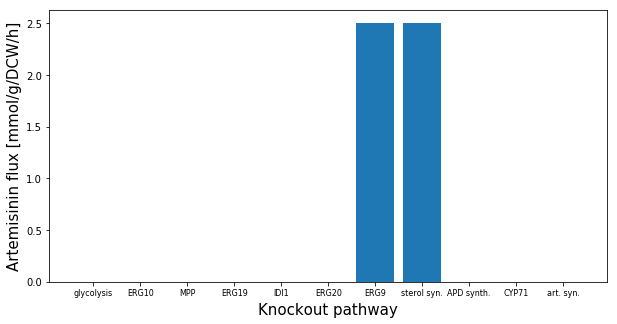

In [109]:
# Make a bar chart with the fluxes
x = np.arange(len(pathway_list))

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(x, np.abs(np.array(art_list)))
ax.set_xticks(x)
ax.set_xticklabels(pathway_list, fontsize=8)
ax.set_xlabel('Knockout pathway',fontsize=15)
ax.set_ylabel('Artemisinin flux [mmol/g/DCW/h]',fontsize=15)
plt.show()
